# Settings

In [1]:
import os
import random
import numpy as np
import math
import numpy.random as rnd
from PIL import Image
import pickle
from sklearn.utils import shuffle

# Read in data

### Path datasets

In [2]:
train_path = os.path.join("../", 'images_background')
validation_path = os.path.join("../", 'images_evaluation')

### Read in function

Make pickle dataset of both images_background and images_evaluation in respectively train- and test sets.

In [3]:
import sys
import numpy as np
from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
import argparse
"""Script to preprocess the omniglot dataset and pickle it into an array that's easy
    to index my character type"""


data_path = '../'
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_validation')
testpath = os.path.join(data_path,'images_test')
save_path = '../omniglot_images/'

lang_dict = {}


def loadimgs(path,n=0):
    #if data not already unzipped, unzip it.
    if not os.path.exists(path):
        print("unzipping")
        os.chdir(data_path)
        os.system("unzip {}".format(path+".zip" ))
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    #we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        if not alphabet.startswith('.'):
            print("loading alphabet: " + alphabet)
            lang_dict[alphabet] = [curr_y,None]
            alphabet_path = os.path.join(path,alphabet)
            #every letter/category has it's own column in the array, so  load seperately
            for letter in os.listdir(alphabet_path):
                if not letter.startswith('.'):
                    cat_dict[curr_y] = (alphabet, letter)
                    category_images=[]
                    letter_path = os.path.join(alphabet_path, letter)
                    for filename in os.listdir(letter_path):
                        if not filename.startswith('.'):
                            image_path = os.path.join(letter_path, filename)
                            image = imread(image_path)
                            category_images.append(image)
                            y.append(curr_y)
                    try:
                        X.append(np.stack(category_images))
                        #edge case  - last one
                    except ValueError as e:
                        print(e)
                        print("error - category_images:", category_images)
                    curr_y += 1
                    lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

X,y,c=loadimgs(train_folder)


with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

X,y,c=loadimgs(valpath)
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((X,c),f)
    
X,y,c=loadimgs(testpath)
with open(os.path.join(save_path,"test.pickle"), "wb") as f:
    pickle.dump((X,c),f)

loading alphabet: Gujarati


/Users/mdeblaauw/anaconda3/envs/research-paper/lib/python3.6/site-packages/ipykernel/__main__.py:47: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Malay_(Jawi_-_Arabic)


KeyboardInterrupt: 

Create pickle dataset of train/val/test datasets

In [ ]:
PATH = "../omniglot_images/" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
with open(os.path.join(PATH, "test.pickle"), "rb") as f:
    (Xtest,ctest) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())
print("test alphabets:")
print(ctest.keys())

# Load in pickle datasets

In [5]:
path = '../omniglot_images/'
data_subsets = ["train", "val", "test"]

data = {}
categories = {}
info = {}
        
for name in data_subsets:
    file_path = os.path.join(path, name + ".pickle")
    print("loading data from {}".format(file_path))
    with open(file_path,"rb") as f:
        (X,c) = pickle.load(f)
        data[name] = X
        categories[name] = c

loading data from ../omniglot_images/train.pickle
loading data from ../omniglot_images/val.pickle
loading data from ../omniglot_images/test.pickle


Every image is 105x105 pixels. Every character exist of 20 same drawn characters

In [6]:
print('train shape')
print(data['train'].shape)
print()
print('val shape')
print(data['val'].shape)
print()
print('test shape')
print(data['test'].shape)

train shape
(964, 20, 105, 105)

val shape
(321, 20, 105, 105)

test shape
(338, 20, 105, 105)


## Create train/validation/test set

In [192]:
def create_train_data(size, s='train'):
    #get train data and shape
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    
    #initialize 2 empty arrays for the input size in a list
    pairs=[np.zeros((size, h, w,1)) for i in range(2)]
    
    #initialize vector for the targets
    targets=np.zeros((size,))
    
    for x in range(size):
        #randomly sample one class (character)
        category = rnd.choice(n_classes,1,replace=False)
        #randomly sample one example from class (1-20 characters)
        idx_1 = rnd.randint(0, n_examples)
        pairs[0][x,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        #randomly sample again one example from class and add last class with modulo
        # ..to ensure not same class pairs are created
        idx_2 = (idx_1 + rnd.randint(0, n_examples)) % n_examples
        #pick images of different class for 1st half and same class for 2nd half
        if x >= size // 2:
            category_2 = category
            targets[x] = 1
        else: 
        #add a random number to the category modulo n classes to ensure 2nd image has
        # ..different category
            idx_2 = rnd.randint(0, n_examples) 
            category_2 = (category + rnd.randint(1,n_classes)) % n_classes
            targets[x] = 0
        pairs[1][x,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        
    return pairs, targets

Create a train- and validation set of 30,000 pairs with 50/50 wrong/good pairs

In [221]:
train_set, train_labels = create_train_data(30000)
val_set, val_labels = create_train_data(20)
test_set, test_labels = create_train_data(3000, s='test')

In [9]:
print('shape first pair train')
print(train_set[0].shape)
print()
print('shape second pair train')
print(train_set[1].shape)
print()
print('shape of labels train')
print(train_labels.shape)
print()
print()
print('shape first pair val')
print(val_set[0].shape)
print()
print('shape second pair val')
print(val_set[1].shape)
print()
print('shape of labels val')
print(val_labels.shape)

shape first pair train
(30000, 105, 105, 1)

shape second pair train
(30000, 105, 105, 1)

shape of labels train
(30000,)


shape first pair val
(10000, 105, 105, 1)

shape second pair val
(10000, 105, 105, 1)

shape of labels val
(10000,)


Reshape into instances, width, height

In [10]:
first = train_set[0].reshape(30000,105,105)
second = train_set[1].reshape(30000,105,105)

Visualise a pair of images

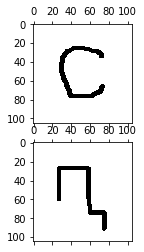

In [19]:
pair = 0
fig,(ax1,ax2) = plt.subplots(2)
ax1.matshow(first[pair],cmap='gray')
ax2.matshow(second[pair],cmap='gray')

In [18]:
from scipy import ndimage

In [29]:
first[0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [45]:
first[0].shape

(105, 105)

In [187]:
shift = np.random.randint(low=-10, high=10,size=2)

In [191]:
shift

array([-2,  8])

In [ ]:
test_set, test_labels 

In [222]:
test_set2 = np.copy(test_set)

In [204]:
test_set[0].shape

(3000, 105, 105, 1)

In [199]:
a = test_set[0][0,:,:,0]

In [201]:
test_set[0][0,:,:,0] = a

In [223]:
images = test_set[0].shape[0]
for i in range(2):
    for j in range(images):
        img = test_set[i][j,:,:,0]
        shift = np.random.randint(low=-10, high=10,size=2)
        degrees = np.random.uniform(low=-90, high=90)
        img2 = ndimage.rotate(img, degrees, reshape=False, cval = 255, order=0)
        new_img = ndimage.shift(img2, shift,  cval = 255, order=0)
        test_set[i][j,:,:,0] = new_img

In [179]:
degrees = np.random.uniform(low=-90, high=90)
new_img = ndimage.rotate(first[1], degrees, reshape=False, cval = 255, order=0)
new_img2 = ndimage.rotate(first[1], degrees + 30, reshape=False, cval = 255, order=0)

In [189]:
new_img = ndimage.shift(first[1], shift,  cval = 255, order=0)
new_img2 = ndimage.shift(first[1], shift,  cval = 255, order=0)

In [231]:
first = test_set[1].reshape(3000,105,105)
second = test_set2[1].reshape(3000,105,105)

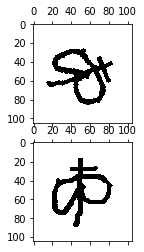

In [234]:
fig,(ax1,ax2) = plt.subplots(2)
ax1.matshow(first[90],cmap='gray')
ax2.matshow(second[90],cmap='gray')

In [103]:
new_img

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [80]:
import scipy.misc

In [83]:
scipy.misc.imsave('../outfile.jpg', first[pair])

/Users/mdeblaauw/anaconda3/envs/research-paper/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':


Generate one N-way set with targets, true image and a set of N characters

In [5]:
def generate_oneshot_set(N_way, s='test'):
    N = N_way
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    indices = rnd.randint(0,n_examples,size=(N,))
    #Get mutually exclusive classes (characters) from test set
    categories = rnd.choice(range(n_classes),size=(N,),replace=False)
    #Set true image as first indice from chosen classes
    true_category = categories[0]
    #Generate 2 character places for true image
    ex1, ex2 = rnd.choice(n_examples,replace=False,size=(2,))
    #Pick test image with true image indice class and one character indice.
    # ..multipli array in N_way
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    #Select N_way set from test set with class and character indices
    support_set = X[categories,indices,:,:]
    #Set first indice as true image, but with ex2 character
    # ..this is to make sure both true images are not the same character
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    #Shuffle 
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [6]:
pairs, targets = generate_oneshot_set(20,"train")

In [8]:
pairs[1].shape

(20, 105, 105, 1)

In [10]:
targets

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# Apply one-shot 20-way task

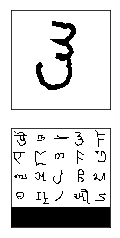

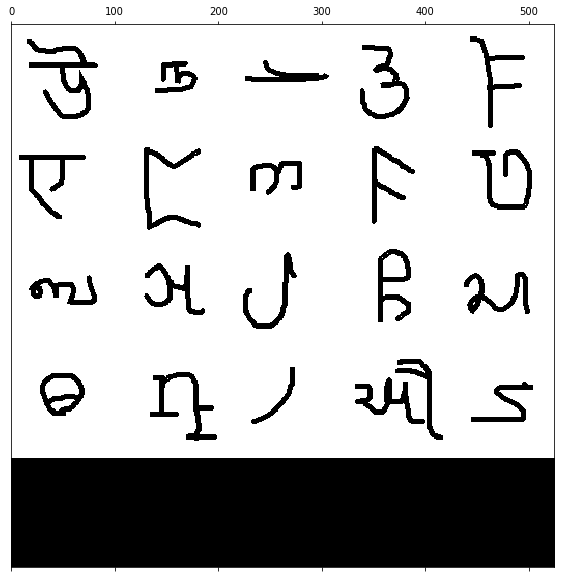

In [119]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    fig,xx = plt.subplots(figsize=(10,10))
    xx.get_yaxis().set_visible(False)
    xx.matshow(img,cmap='gray')
#example of a one-shot learning task
pairs, targets = generate_oneshot_set(20,"train")
plot_oneshot_task(pairs)